# From Prompts to Workflows

In this notebook, we'll see why a single LLM prompt breaks down on multi-step tasks and how LangGraph provides **structure, state, and control flow** to fix it.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

In [2]:
from langchain_openai import ChatOpenAI

# We use OpenRouter as our LLM gateway — swap models by changing the model string
llm = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

## Why single prompts break down

Let's try asking a model to do three things in one shot:
1. Write a product description for a fictional AI tool
2. Critique the description for clarity, tone, and persuasiveness
3. Rewrite an improved version based on the critique

This is a common pattern — you want a pipeline of steps, but you cram it all into one prompt.

In [3]:
# One prompt trying to do three things at once
response = llm.invoke(
    "Write a product description for a fictional AI-powered meeting assistant called 'MeetingMind'. "
    "Then critique the description for clarity, tone, and persuasiveness. "
    "Then rewrite an improved version based on the critique."
)
print(response.content)

**Original Product Description:**

Meet MeetingMind, your ultimate AI-powered meeting assistant designed to revolutionize the way you handle meetings. With advanced natural language processing and real-time transcription, MeetingMind captures every word, summarizes key points, and generates actionable task lists automatically. It integrates seamlessly with your calendar and communication tools, ensuring effortless scheduling and follow-ups. Whether you’re in a brainstorming session, client call, or team sync, MeetingMind keeps you focused by reducing manual note-taking and eliminating misunderstandings. Boost productivity, stay organized, and never miss a detail with MeetingMind — your smart partner for smarter meetings.

---

**Critique:**

- **Clarity:**  
  The description clearly explains the main features — transcription, summarization, task automation, and integration. However, some phrases like "advanced natural language processing" and "integrates seamlessly with your calendar 

Notice how the model tries to do everything in one pass. The "critique" is shallow because the model already committed to the description and doesn't want to contradict itself. The "rewrite" barely changes anything.

This *kind of* works for simple tasks, but the model has no way to:
- **Separate generation from evaluation** — it critiques its own work in the same breath
- **Actually improve** — the critique and rewrite are performative, not substantive
- **Debug** — if the final copy is bad, which step failed?

For anything beyond toy examples, we need **structure**.

## LangGraph: Graphs as a better abstraction

LangGraph models workflows as **directed graphs**:
- **Nodes** = individual processing steps (each does one focused thing)
- **Edges** = connections that pass state between steps
- **State** = a typed dictionary that carries context through the graph

Let's rebuild the same task as a 3-node graph.

## Side-by-side comparison

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class WorkflowState(TypedDict):
    product_name: str
    draft: str
    critique: str
    final_copy: str


def generate_node(state: WorkflowState) -> dict:
    """Step 1: Write an initial product description."""
    response = llm.invoke(
        f"Write a compelling product description (2-3 paragraphs) for a fictional "
        f"AI-powered tool called '{state['product_name']}'. "
        f"It's an AI meeting assistant that joins video calls, takes notes, "
        f"identifies action items, and sends follow-up summaries."
    )
    return {"draft": response.content}


def critique_node(state: WorkflowState) -> dict:
    """Step 2: Critically evaluate the draft — separate LLM call, fresh perspective."""
    response = llm.invoke(
        f"You are a senior copywriter reviewing a junior writer's work. "
        f"Critique this product description for:\n"
        f"- **Clarity**: Is it easy to understand? Any jargon or vague claims?\n"
        f"- **Tone**: Is it professional yet engaging? Too salesy or too flat?\n"
        f"- **Persuasiveness**: Does it make you want to try the product? What's missing?\n\n"
        f"Be specific and constructive. Point to exact phrases that need improvement.\n\n"
        f"Product description:\n{state['draft']}"
    )
    return {"critique": response.content}


def refine_node(state: WorkflowState) -> dict:
    """Step 3: Rewrite the description incorporating the critique."""
    response = llm.invoke(
        f"Rewrite this product description, addressing every point in the critique below. "
        f"Keep what works, fix what doesn't.\n\n"
        f"Original draft:\n{state['draft']}\n\n"
        f"Critique:\n{state['critique']}\n\n"
        f"Rewritten description:"
    )
    return {"final_copy": response.content}


# Build the graph
graph = StateGraph(WorkflowState)
graph.add_node("generate", generate_node)
graph.add_node("critique", critique_node)
graph.add_node("refine", refine_node)

graph.add_edge(START, "generate")
graph.add_edge("generate", "critique")
graph.add_edge("critique", "refine")
graph.add_edge("refine", END)

app = graph.compile()

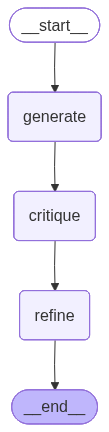

In [5]:
# Visualize the graph topology
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
# Run it
result = app.invoke({"product_name": "MeetingMind"})

print("=== Draft ===")
print(result["draft"])
print("\n=== Critique ===")
print(result["critique"])
print("\n=== Final Copy ===")
print(result["final_copy"])

=== Draft ===
Meet **MeetingMind**, your ultimate AI-powered meeting assistant designed to transform the way you collaborate. Seamlessly integrating with your video calls, MeetingMind actively participates by capturing every essential detail — from key points discussed and decisions made to action items assigned. Say goodbye to frantic note-taking or missing critical insights; MeetingMind’s real-time transcription and intelligent summarization ensure nothing slips through the cracks, allowing you to stay fully engaged in the conversation.

But MeetingMind doesn’t stop at just capturing information. After the meeting ends, it instantly organizes and prioritizes action items, assigning responsibilities and deadlines with impeccable accuracy. Within moments, each participant receives a clear, concise follow-up summary, keeping the whole team aligned and accountable without any extra effort. Whether you’re managing large projects or daily stand-ups, MeetingMind streamlines your workflow, e

Notice the difference — the critique is **genuinely critical** because it's a separate LLM call that doesn't have to be polite about its own prior work. The refined version actually addresses the feedback.

This is the **generate → critique → refine** pattern, and it's one of the most powerful things you can do with a graph. No tools, no search — just structured self-reflection.

| Single Prompt | LangGraph Workflow |
|---|---|
| One monolithic call | Three focused steps |
| Self-critique is shallow | Critique is a separate, honest evaluation |
| No intermediate state | State is explicit and typed |
| Can't add branching or loops | Could easily add a loop to refine multiple times |

In the next notebook, we'll learn the **mechanics** of how LangGraph makes this work — `StateGraph`, reducers, conditional edges, and checkpointing.